## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from Functions import tsPlot
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Enable GPU

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Import Data

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the dataframe called 'df_ret' and 'df_exog'

In [3]:
# Read the csv file into a pandas DataFrame
df_ret = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')
df_exog = pd.read_csv('../DataManagement/nvidia_exogenous.csv', parse_dates=['DATE'], index_col='DATE')

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df_ret = df_ret.loc[start_date:end_date].copy()
df_exog = df_exog.loc[start_date:end_date].copy()

## Plots

As usual, we qucikly plot the time series to make sure that looks as we expect

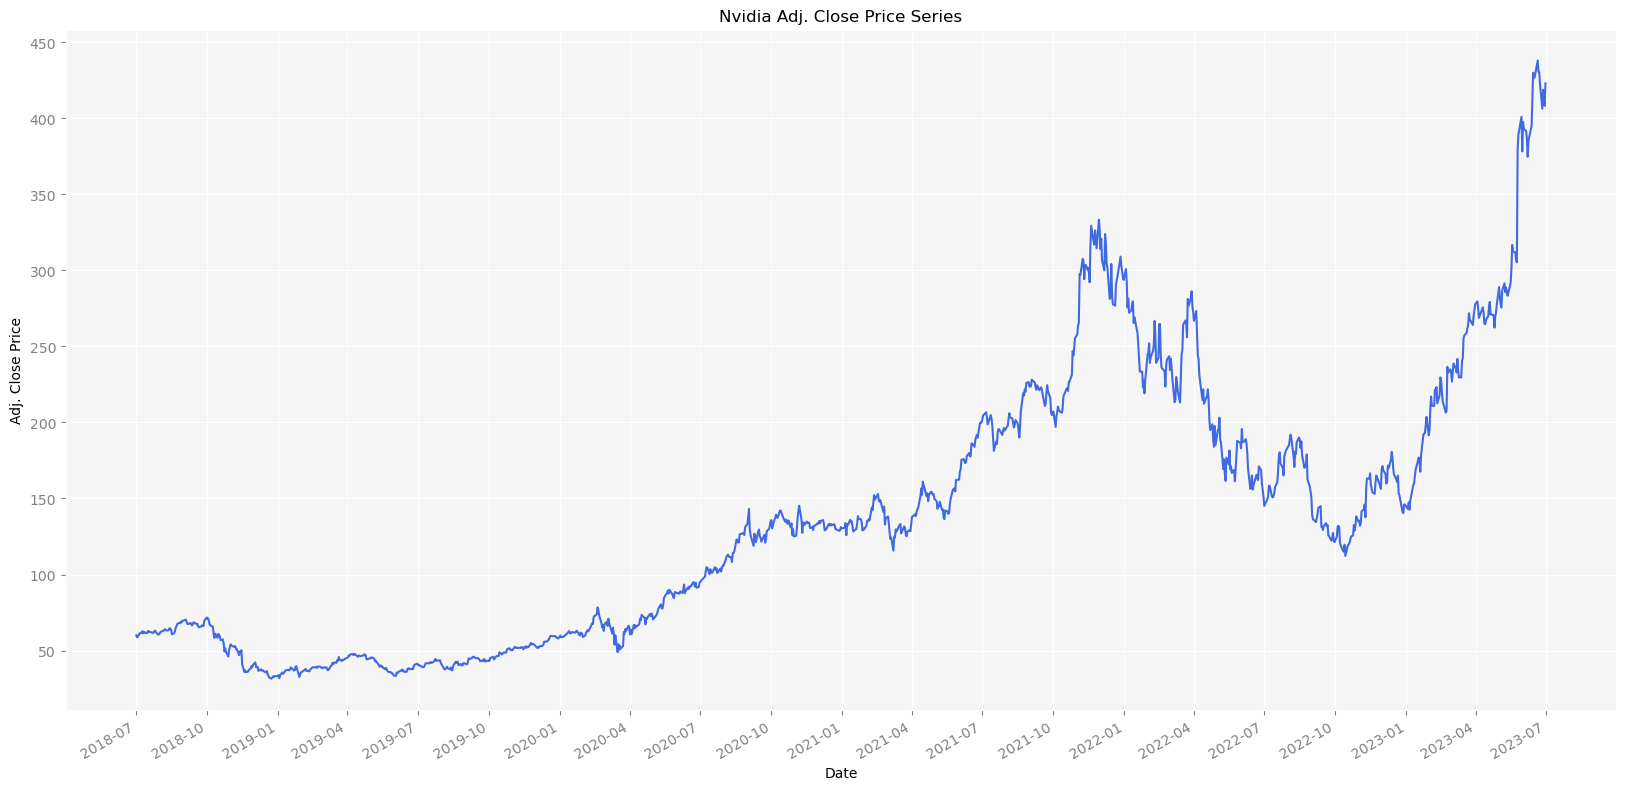

In [4]:
tsPlot(df_ret['NVDA_CLOSE'], "Nvidia", "Adj. Close Price")

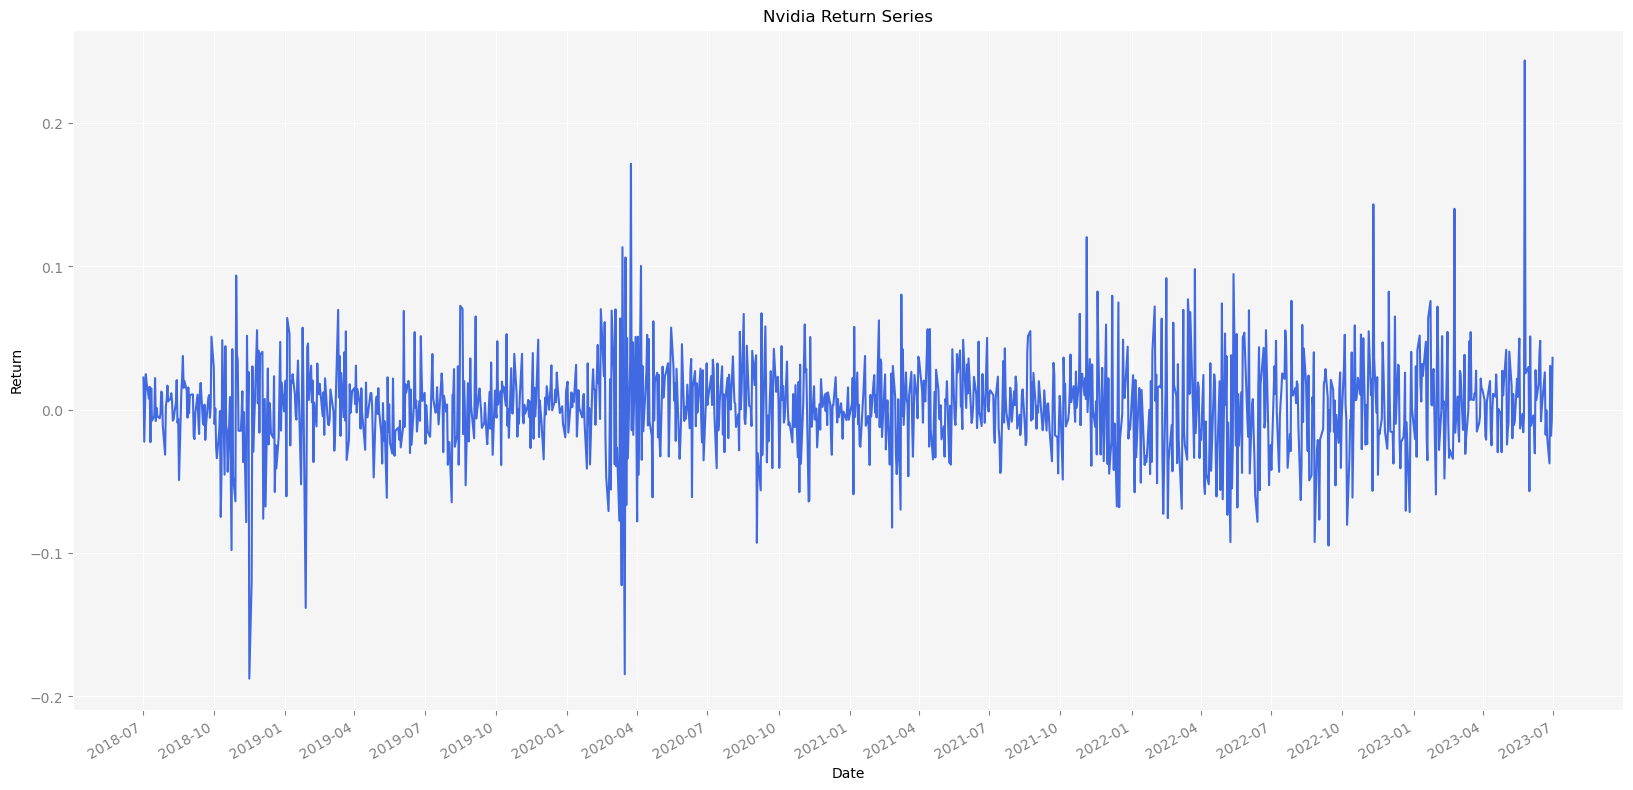

In [5]:
tsPlot(df_ret['NVDA_RET'], "Nvidia", "Return")

## Data Pre-Processing

### Some comments on data pre-processing

When transitioning from traditional time series analysis techniques like ARMA to more advanced methods like LSTM for forecasting stock prices, the choice of data representation becomes an important consideration. While using log returns is a common approach in ARMA modeling to achieve stationarity, the same concept does not necessarily apply directly to LSTM models.

In an ARMA model, the logarithmic transformation is often used to stabilize the variance of the time series and make it stationary. The ARMA model assumes that the data has constant variance and the logarithmic transformation helps in achieving this property for certain financial time series, including stock prices.

However, LSTM models are designed to handle more complex dependencies and can capture long-term patterns and non-linear relationships. These models are capable of handling non-stationary data to some extent. Therefore, it is not a strict requirement to use log returns in an LSTM model for stock price forecasting.

The choice of input representation (log returns, simple returns, or prices) for an LSTM model depends on various factors, including the characteristics of the data and the specific problem you are trying to solve:

1. **Log Returns:** Log returns are commonly used when you want to stabilize the variance of the data and make it stationary. This can be helpful when you are using traditional statistical models like ARMA or when the stock price series exhibits strong volatility clustering. However, LSTM models have the ability to implicitly handle some non-stationarity, so using log returns may not be necessary in all cases.

2. **Simple Returns:** Simple returns (percentage changes in prices) are a straightforward representation and can be directly used as inputs to an LSTM model. They have the advantage of being interpretable and are often used in practice for forecasting financial time series with deep learning models.

3. **Prices:** Using raw prices as inputs to an LSTM model can be informative as it includes the original levels of the data. However, using prices directly may introduce spurious correlations and trends, which can negatively impact the model's performance. It is generally recommended to use some form of returns when dealing with financial time series to avoid this issue.

Dealing with data on different scales and different data types is a common challenge in many machine learning and forecasting tasks, including time series analysis with LSTM models. It is important to handle these differences appropriately to ensure that the model can effectively learn from the data and make accurate predictions. Here are some strategies to handle data with varying scales and types:

1. **Normalization/Standardization:** One way to handle data on different scales is to normalize or standardize the numerical features. Normalization scales the data to a range between 0 and 1, while standardization transforms the data to have zero mean and unit variance. This process helps the model by giving equal importance to all features regardless of their original scales. You can apply normalization or standardization to the numerical features before feeding them into the LSTM model.

2. **Categorical Variables:** For categorical variables like the earnings call flag (0 or 1), you should convert them to one-hot encodings. This means creating new binary columns for each category and indicating the presence (1) or absence (0) of that category. In the case of the earnings call flag, you would have two new columns: "Earnings_Call_Yes" and "Earnings_Call_No."

3. **Handling Binary Data in LSTM:** For handling binary data in LSTM, you can represent binary features using a single binary input neuron (0 or 1) instead of one-hot encoding. LSTM models can naturally work with binary inputs.

4. **Feature Scaling:** If you have a mix of numerical and one-hot encoded categorical features, ensure that they are all on a similar scale. After one-hot encoding, the binary features will already be on the same scale (0 or 1), but numerical features should be normalized or standardized, as mentioned earlier.

5. **Handling Time Series and Exogenous Data:** If you have multiple types of data (e.g., time series returns and exogenous features like EPS figures and trade volume), you can use a multi-input LSTM architecture. In this setup, you provide different inputs for the LSTM model to process. One input stream will be the time series returns, and the other input streams will be the exogenous features. The LSTM can learn to combine and utilize information from both sources.

6. **Data Integration:** Ensure that your data is aligned properly. The time series returns and exogenous features should be synchronized by their timestamps so that the LSTM can effectively understand the relationships between them.

7. **Loss Function and Output Layer:** Depending on the specific forecasting task (e.g., regression or classification), choose an appropriate loss function and output layer for the LSTM. For regression tasks, mean squared error (MSE) is often used, while for classification tasks, binary cross-entropy or categorical cross-entropy may be used.

### Create Sequences

Here we define a function that transforms the data into the format requred by the LSTM with parameters for lookback period.

In [6]:
def prepare_data_lstm(data, n_steps, column):
    column_names = [column]
    data = dc(data)  # make deep copy of the input data

    for i in range(1, n_steps+1):
        column_name = f'{column}(t-{i})'
        column_names.append(column_name)
        data[column_name] = data[column].shift(i)

    data.dropna(inplace=True)
    data = data.loc[:, data.columns.intersection(column_names)]

    return data

In [7]:
lookback = 7
shifted_returns = prepare_data_lstm(df_ret, lookback, 'NVDA_CLOSE')       
shifted_returns_np = shifted_returns.to_numpy()    # convert data to numpy matrix

Now we perform standardisation on the dataset

In [8]:
ret_scaler = MinMaxScaler(feature_range=(-1,1))    # scale to range -1 to 1
shifted_returns_np_scaled = ret_scaler.fit_transform(shifted_returns_np)

Now we split the standardised returns into our X and y vectors

In [9]:
X = shifted_returns_np_scaled[:, 1:]
y = shifted_returns_np_scaled[:, 0]

X = dc(np.flip(X, axis=1)) # flip X so that it goes, for example, t-7, t-6, t-5....

Now perform a train/test split where the first 95% of the data is used for training and the last 5% for testing

In [10]:
split_index = int(len(X) * 0.95)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 7), (63, 7), (1188,), (63,))

LSTM's in this workflow require an additional dimension at the end so we perform the relevant re-shaping

In [11]:
X_train, X_test = X_train.reshape((-1, lookback, 1)), X_test.reshape((-1, lookback, 1))
y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 7, 1), (63, 7, 1), (1188, 1), (63, 1))

Then we convert the matrices into tensor objects

In [12]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

Now we define a class that we will use to turn these individual matrices into train and test datasets

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

Now we wrap our datasets in data loaders

In [14]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Send the batches to our compute device (GPU:0 in this case as we defined in the 'setup' section)

In [15]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


## LSTM Model

The inputs of the below class are as follows:

* input_size : number of features
* hidden_size : dimension of hidden layers
* num_stacked_layers : number of layers because we can stack LSTM's since as we run through them, they will actually create sequences themselves

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [17]:
input_size = 1
hidden_size = 4
num_stacked_layers = 1

model = LSTM(input_size, hidden_size, num_stacked_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Train function

In [30]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 10 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

Validate function

In [31]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

Train the model

In [32]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 0.001037
Batch 20, Loss: 0.000945
Batch 30, Loss: 0.000916
Batch 40, Loss: 0.000856
Batch 50, Loss: 0.000998
Batch 60, Loss: 0.000808
Batch 70, Loss: 0.000882

Val Loss: 0.018
***************************************************

Epoch: 2
Batch 10, Loss: 0.000914
Batch 20, Loss: 0.001153
Batch 30, Loss: 0.000735
Batch 40, Loss: 0.000967
Batch 50, Loss: 0.000655
Batch 60, Loss: 0.000669
Batch 70, Loss: 0.000898

Val Loss: 0.020
***************************************************

Epoch: 3
Batch 10, Loss: 0.000753
Batch 20, Loss: 0.000717
Batch 30, Loss: 0.000814
Batch 40, Loss: 0.001125
Batch 50, Loss: 0.000610
Batch 60, Loss: 0.000809
Batch 70, Loss: 0.000792

Val Loss: 0.019
***************************************************

Epoch: 4
Batch 10, Loss: 0.000737
Batch 20, Loss: 0.001040
Batch 30, Loss: 0.000747
Batch 40, Loss: 0.000799
Batch 50, Loss: 0.000878
Batch 60, Loss: 0.000736
Batch 70, Loss: 0.001092

Val Loss: 0.018
*************************************

## LSTM Training Predictions

Plots the predicted vs actual data

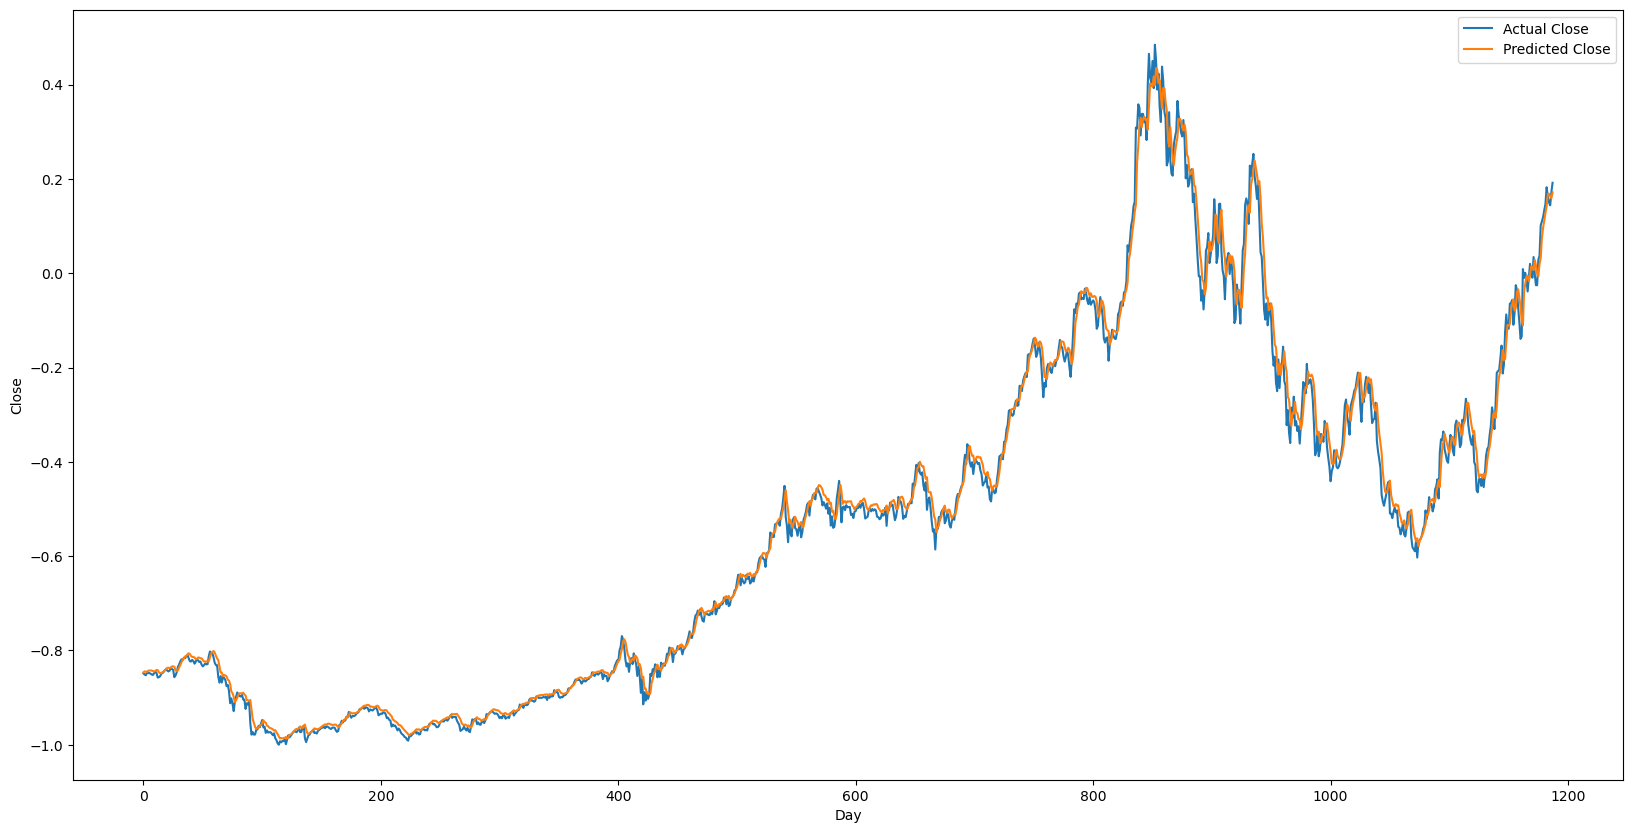

In [34]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()    # we have to move this to the cpu now because numpy cannot access the gpu

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

The above data is still in the standardised form so now we perform some transformations to revert it back to the original scale

In [36]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))  # here we are basically trying to make a dummy matrix that 'looks like' the original matrix of data that we started with
dummies[:, 0] = train_predictions
dummies = ret_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 62.74172931,  63.12569092,  63.06739999, ..., 268.05910975,
       267.09415329, 269.68615463])

In [37]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = ret_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 62.23390404,  61.76076738,  61.48331908, ..., 264.07269411,
       269.81207198, 273.8016651 ])

Now plot the same as before but with our 'un-scaled' data

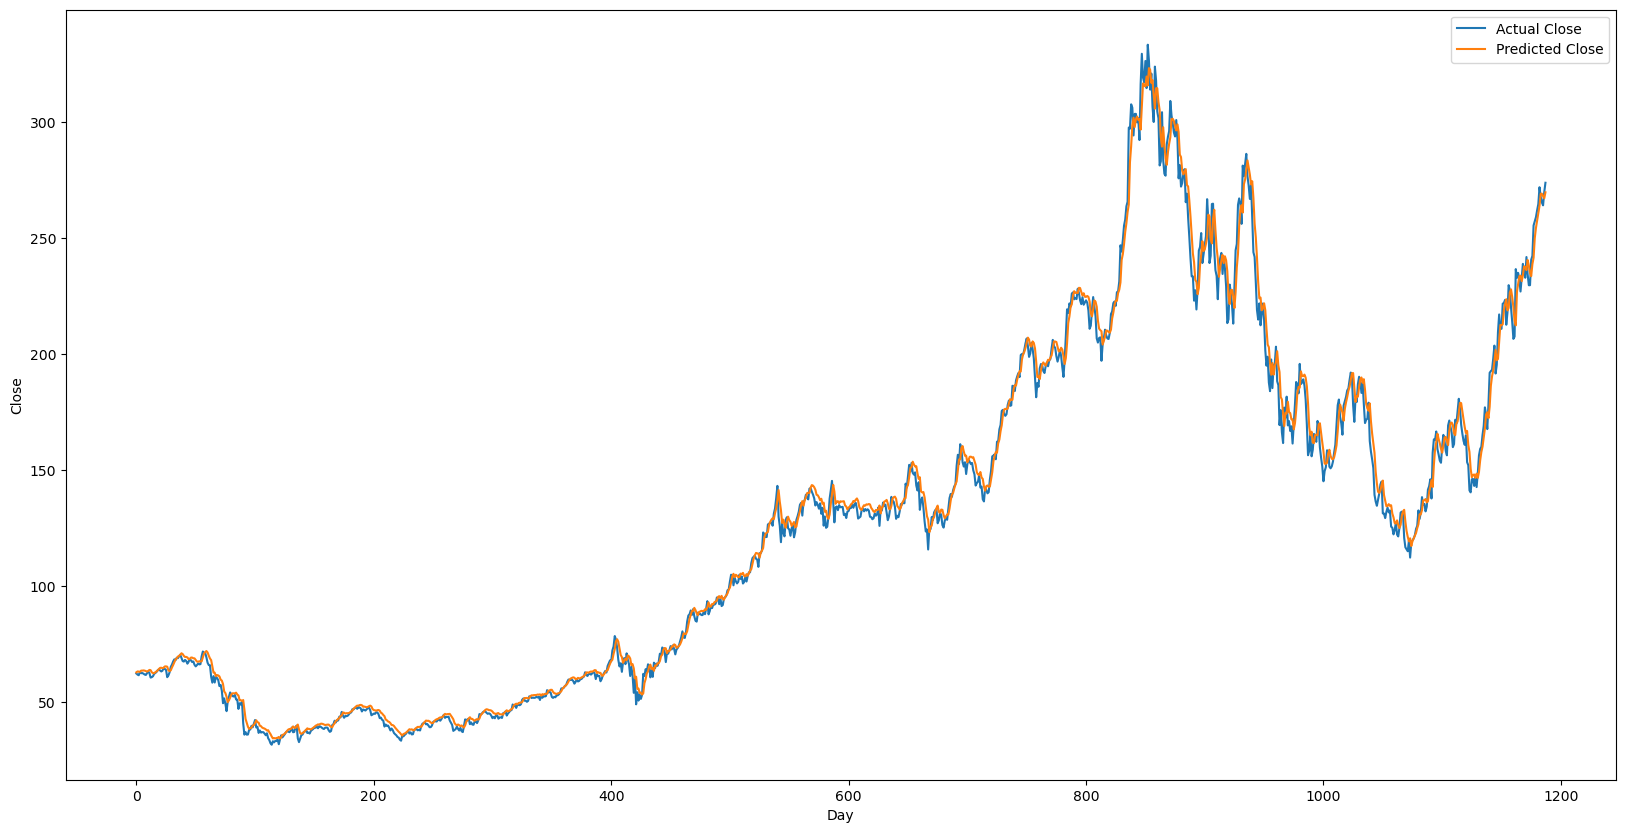

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## LSTM Test Predictions

As before, we reverse the scaling on the predictions and y values

In [40]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = ret_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [43]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = ret_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

Then we plot them

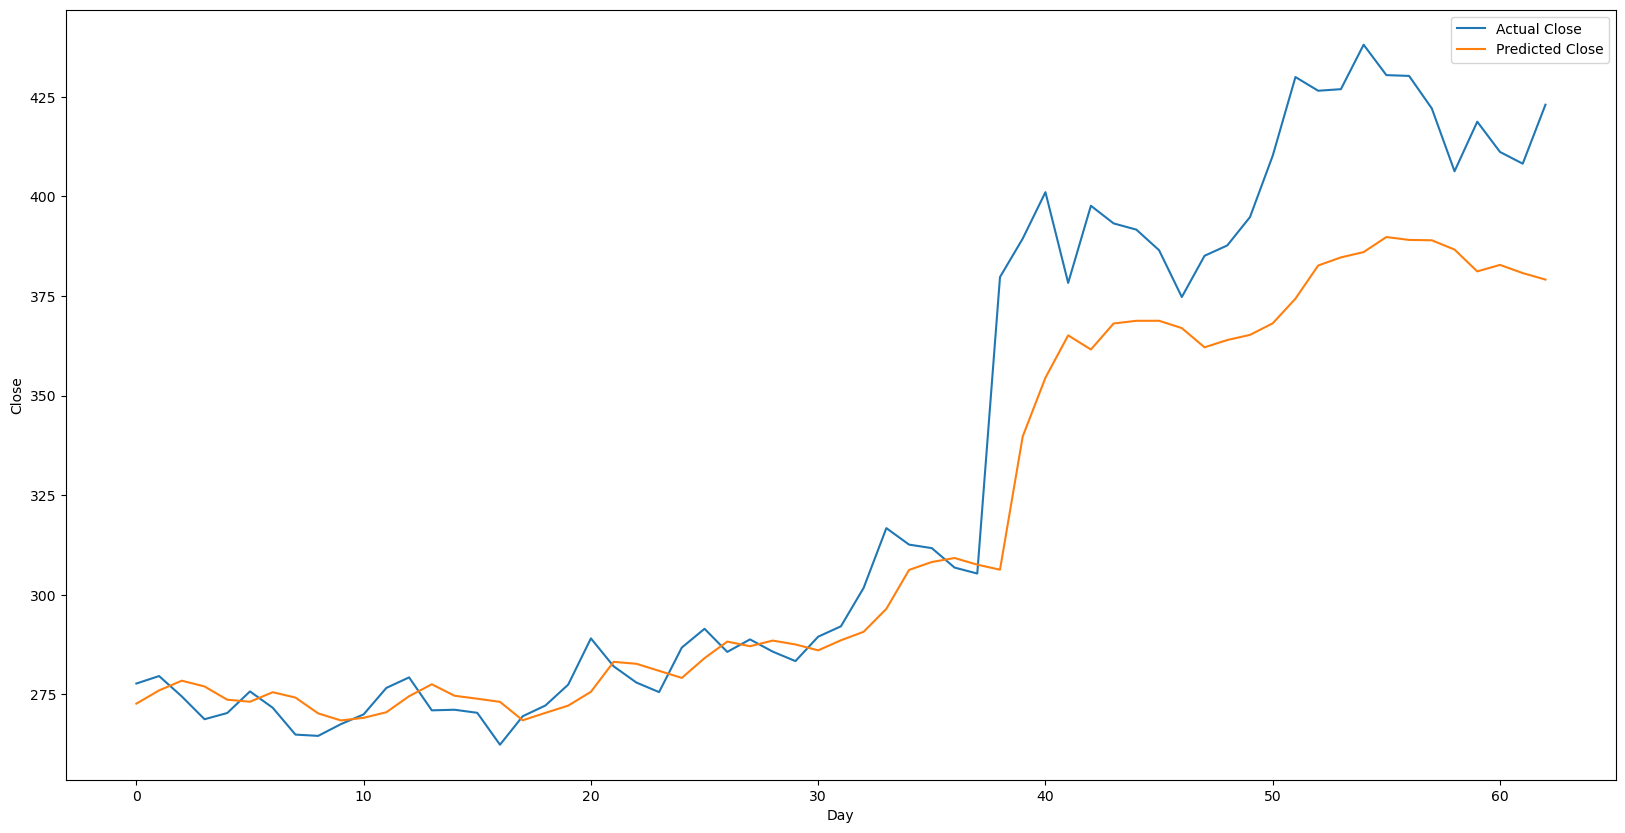

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()